In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
from tensorflow.keras.regularizers import l2
from wordcloud import WordCloud

%matplotlib inline

In [2]:
# !pip install wordcloud
# !pip install tensorflow.keras

## Reding ANIMELIST.CSV

In [3]:
import os

INPUT_DIR = os.path.join("..","artifacts","raw")


In [4]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv",
                        low_memory=True,
                        usecols=['user_id','anime_id','rating'])


In [5]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [6]:
print(len(rating_df))

5000000


## DATA PROCESSING

- Uniques USer Ratings
- filtered User with rating > 400 animes
- min,max,avg and scaling (X-min/max-min)
- Encoded and decoded mappings for user and anime
- create new user & anime cols with encoded mappping in df
- shuffled and Split data into X  & y and later into train and test
- create lists for user and anime


In [7]:
n_ratings = rating_df['user_id'].value_counts()
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [8]:
rating_df = rating_df[rating_df['user_id'].isin(n_ratings[n_ratings>=400].index)].copy()
len(rating_df)

3246641

In [9]:
min_rating = min(rating_df['rating'])
max_rating = max(rating_df['rating'])
avg_rating = np.mean(rating_df['rating'])

print(f"Min Rating: {min_rating}\nMax Rating : {max_rating}\nAverage Rating: {avg_rating}")

Min Rating: 0
Max Rating : 10
Average Rating: 4.122732695114736


In [10]:
# scale rating into 0-1 
rating_df['rating'] = rating_df['rating'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [11]:
rating_df['rating'].head(10)

213    0.0
214    1.0
215    0.0
216    0.0
217    0.0
218    0.8
219    0.8
220    0.9
221    0.0
222    0.0
Name: rating, dtype: float64

In [12]:
print(f"Scaled Min :{min_rating} \nScaled max: {max_rating}\nScaled Avg: {avg_rating}")

Scaled Min :0 
Scaled max: 10
Scaled Avg: 4.122732695114736


In [13]:
# Duplicates
rating_df.duplicated().sum()

np.int64(0)

In [14]:
# Missing values
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [15]:
# Unique USERS
user_ids = rating_df['user_id'].unique().tolist()
# Encoded users
user2user_encoded = { x : i for i,x in enumerate(user_ids)}
# Decoded users
user2user_decoded = { i : x for i,x in enumerate(user_ids)}
# Create unique user cols and ma into `rating_df`
rating_df['user'] = rating_df['user_id'].map(user2user_encoded)

In [16]:
n_users = len(user2user_encoded)
n_users

4203

In [17]:
## 11054 : 12 --> user2user encoded
## 12 : 11054 --> user2user decocded

In [18]:
anime_ids = rating_df['anime_id'].unique().tolist()
anime2anime_encoded = {x : i for i,x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i,x in enumerate(anime_ids)}
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoded) 

In [19]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [20]:
# we add randomness in our data so that our model can predcit on real like data
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


# COLS

ACTUAL  --->    user_id	anime_id

ENCODED --->	user	anime

In [21]:
X = rating_df[['user', 'anime']].values
y = rating_df['rating']

In [22]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [23]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices :],
)

In [24]:
len(X_test), len(y_test)

(1000, 1000)

In [25]:
# TYpe of Xtrain Xtest since model need np.arrays
type(X_train)

numpy.ndarray

In [26]:
# create sepate 2 rrays each for `user` features and `anime` feature
# Stores        USER data       ANIME data
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [27]:
type(X_train_array)

list

In [28]:
type(X_train_array[1])

numpy.ndarray

## MODEL ARCHITECTURE

In [84]:
# Create a tensorflow model 
def RecommenderNet():
    embedding_size = 128

    user = Input(name='user', shape=[1])

    user_embedding = Embedding(name='user_embedding', 
                               input_dim = n_users,
                               output_dim = embedding_size,
                               embeddings_regularizer=l2(1e-5))(user)
    anime = Input(name='anime', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', 
                               input_dim = n_anime,
                               output_dim = embedding_size,
                               embeddings_regularizer=l2(1e-5))(anime)
    
    # DOT Layer - dot product ---- similarity
    x = Dot(name='dot_product',
            normalize = True,
            axes = 2)([user_embedding, anime_embedding])
    
    # Flatten all output --- 128 dimenation vector into 1 dimensional
    x = Flatten()(x)

    # Dense, BatchNormaliztion, Activatio
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    # make a model Layer
    model = Model(inputs=[user, anime], outputs=x)
    # model.compile(loss='binary_crossentropy', metrics=['mae', 'mse'], optimizer='Adam')
    model.compile(loss='mean_squared_error', metrics=['mae', 'mse'], optimizer='Adam')

    return model



In [85]:
model = RecommenderNet()

In [86]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [87]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch<ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    elif epoch<ramup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch-ramup_epochs-sustain_epochs)+min_lr

In [88]:
# Callbacks
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   save_weights_only=True,
                                   monitor="val_loss",
                                   mode="min",
                                   save_best_only=True)

early_stopping = EarlyStopping(patience=3,
                               monitor="val_loss",
                               mode="min",
                               restore_best_weights=True)

In [89]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [90]:
# Train the model -
# Store insisde `history` var so we can get grphs later

history = model.fit(
        x = X_train_array,
        y = y_train,
        batch_size=batch_size,
        epochs =20,
        verbose=1,
        validation_data = (X_test_array, y_test),
        callbacks = my_callbacks
    )

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 42s 115ms/step - loss: 0.2198 - mae: 0.3820 - mse: 0.1973 - val_loss: 0.1974 - val_mae: 0.3689 - val_mse: 0.1751 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 33s 102ms/step - loss: 0.2179 - mae: 0.3807 - mse: 0.1959 - val_loss: 0.2185 - val_mae: 0.3804 - val_mse: 0.1968 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 34s 105ms/step - loss: 0.2148 - mae: 0.3784 - mse: 0.1935 - val_loss: 0.2185 - val_mae: 0.3807 - val_mse: 0.1975 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 34s 104ms/step - loss: 0.2106 - mae: 0.3751 - mse: 0.1900 - val_loss: 0.2159 - val_mae: 0.3793 - val_mse: 0.1958 - learning_rate: 3.4000e-05


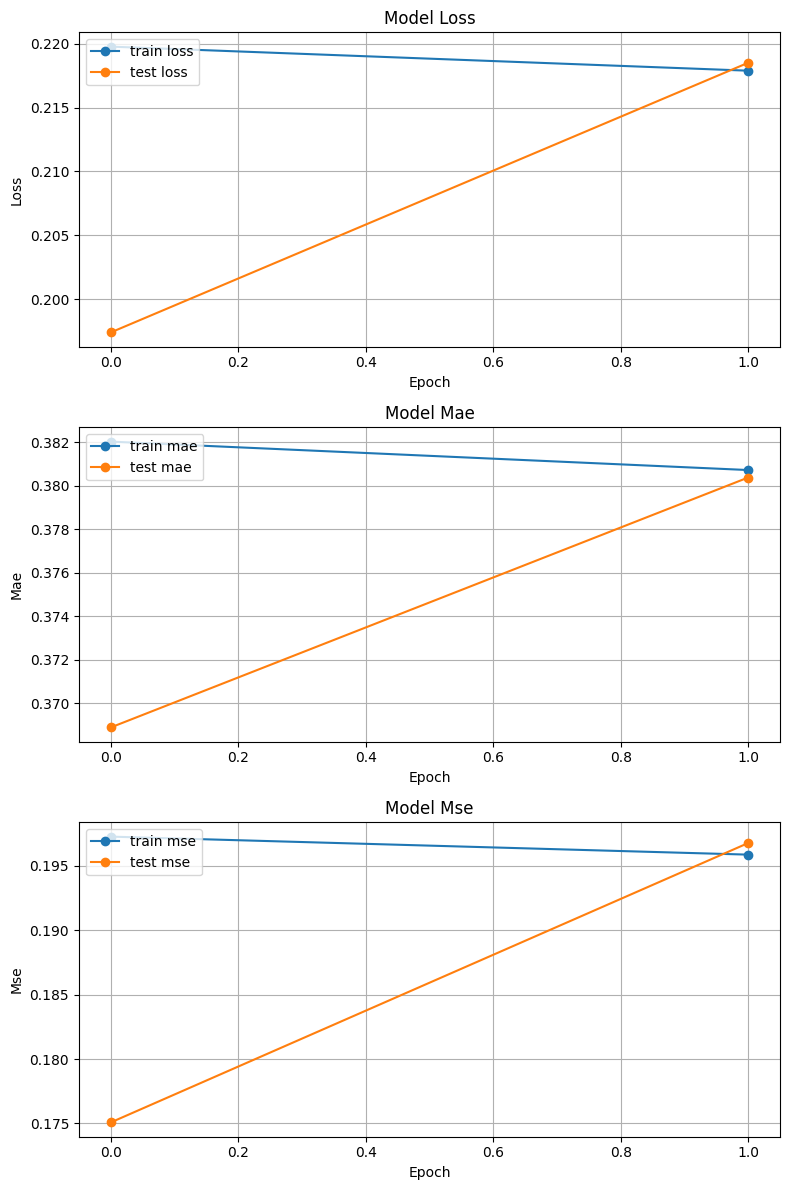

In [91]:
metrics = ["loss", "mae", "mse"]

# Create subplots
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2], marker="o", label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker="o", label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel("Epoch")
    ax.legend(loc="upper left")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [92]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights,axis=1).reshape((-1,1))
    return weights

In [93]:
anime_weights = extract_weights("anime_embedding", model)


In [94]:
user_weights = extract_weights('user_embedding', model)

## READING ANIME.CSV 

In [95]:
anime_df = pd.read_csv(INPUT_DIR+"/anime.csv",
                       low_memory=True)
anime_df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [97]:
anime_df = anime_df.replace('Unknown', np.nan)

In [98]:
anime_df.head(2)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [99]:
# To get English Name when name is unknow get Name
def getAnimeName(anime_id):
    try:
        name = anime_df[anime_df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = anime_df[anime_df.anime_id == anime_id].Name.values[0]
    except:
        print('Error')
    return name

In [100]:
anime_df["anime_id"] = anime_df["MAL_ID"]
anime_df["eng_version"] = anime_df["English name"]
anime_df["eng_version"] = anime_df.anime_id.apply(lambda x:getAnimeName(x))

In [102]:
getAnimeName(67)

'Basilisk'

In [103]:
getAnimeName(6702)

'Fairy Tail'

In [104]:
# Sort the anime df by score with descending order

anime_df.sort_values(by=["Score"],
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")


In [105]:
anime_df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [106]:
# Select Columns needed for analysis
anime_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [108]:
anime_df = anime_df[["anime_id" , "eng_version","Score","Genres","Episodes","Type","Premiered","Members"]]
anime_df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121


In [109]:
# ANIME-ID or ANIME NAme will return the result of it
# 

def getAnimeFrame(anime,anime_df):
    if isinstance(anime,int):
        return anime_df[anime_df.anime_id == anime]
    if isinstance(anime, str):
        return anime_df[anime_df.eng_version == anime]

In [110]:
getAnimeFrame(40028 , anime_df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [111]:
getAnimeFrame('Steins;Gate', anime_df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


## Reading ANIME_WITH_SYNOPSIS.CSV

In [114]:
# Select COLS
cols = ['MAL_ID', 'Name','Genres', 'sypnopsis']

In [115]:
synopsis_df = pd.read_csv(INPUT_DIR+'/anime_with_synopsis.csv', usecols=cols)

In [116]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [117]:
# retunr Synopsis for anime_id or Anime_name
def getSynopsis(anime,anime_df):
    if isinstance(anime,int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [118]:
getSynopsis(40028 , synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [119]:
getSynopsis("Steins;Gate",synopsis_df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

# Content/ITEM BAsed Recommendation SYStem

In [120]:
pd.set_option('max_colwidth', None)

In [121]:
def find_similar_animes(name, 
                        anime_weights,
                        anime2anime_encoded,
                        anime2anime_decoded,
                        anime_df,
                        synopsis_df,
                        n=10,
                        return_dist=False, 
                        neg=False):
    try:
        # Get the index of the anime based on its name
        index = getAnimeFrame(name, anime_df).anime_id.values[0]  # gets index value
        encoded_index = anime2anime_encoded.get(index)  # Get encoded index

        if encoded_index is None:
            raise ValueError(f"Encoded index for anime '{name}' not found.")

        # Get the embeddings (weights)
        weights = anime_weights

        # Compute the similarity (dot product between weights)
        dists = np.dot(weights, weights[encoded_index])  # Compute the cosine similarity
        sorted_dists = np.argsort(dists)  # Sort distances (ascending)

        n = n + 1  # To exclude the query anime itself from results

        if neg:
            closest = sorted_dists[:n]  # Return the farthest anime
        else:
            closest = sorted_dists[-n:]  # Return the closest anime

        print(f"Anime closest to {name}:")

        if return_dist:
            return dists, closest

        SimilarityArr = []

        # Loop through the closest anime and gather metadata
        for close in closest:
            decoded_id = anime2anime_decoded.get(close)

            if decoded_id is None:
                continue  # Skip if no valid decoded ID

            # Fetch metadata for each similar anime
            anime_frame = getAnimeFrame(decoded_id, anime_df)
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            synopsis = getSynopsis(decoded_id, synopsis_df)
            similarity = dists[close]

            SimilarityArr.append({
                'anime_id': decoded_id,
                'name': anime_name,
                'similarity': similarity,
                'genre': genre,
                'synopsis': synopsis
            })

        # Create a DataFrame with results and sort by similarity
        Frame = pd.DataFrame(SimilarityArr).sort_values(by='similarity', ascending=False)
        # Exclude the original anime and drop the 'anime_id' column
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except Exception as e:
        print(f"Error: {e}")
        return None


In [62]:
# getAnimeFrame(40028, anime_df).anime_id.values[0]

In [63]:
# anime2anime_encoded.get(40028)

In [64]:
# np.argsort(np.dot(anime_weights, anime_weights[1666]))

In [122]:
find_similar_animes('Steins;Gate',
                    anime_weights,
                    anime2anime_encoded,
                    anime2anime_decoded,
                    anime_df,
                    synopsis_df,)

Anime closest to Steins;Gate:


,name,similarity,genre,synopsis
9,Hunter x Hunter,0.352796,"Action, Adventure, Super Power, Fantasy, Shounen","Hunters are specialized in a wide variety of fields, ranging from treasure hunting to cooking. They have access to otherwise unavailable funds and information that allow them to pursue their dreams and interests. However, being a hunter is a special privilege, only attained by taking a deadly exam with an extremely low success rate. Gon Freecss, a 12-year-old boy with the hope of finding his missing father, sets out on a quest to take the Hunter Exam. Along the way, he picks up three companions who also aim to take the dangerous test: the revenge-seeking Kurapika, aspiring doctor Leorio Paladiknight, and a mischievous child the same age as Gon, Killua Zoldyck. Hunter x Hunter is a classic shounen that follows the story of four aspiring hunters as they embark on a perilous adventure, fighting for their dreams while defying the odds."
8,My Graduation: Mirai,0.343381,"Kids, Music",usic video for the song My Graduation: Mirai by Mink (Mie Yamamoto) that was featured on NHK's Minna no Uta program. The video was animated by Toshio Nishiuchi.
7,Nutsberry Town,0.333107,"Kids, Slice of Life","* Based on Chirorin Mura To Kurumi No Ki (Chirorin Village and the Walnut Tree), a children's puppet show broadcast on NHK between 1959 and 1964. This series was brought back to exploit parents' nostalgia. Nutsberry Town is a beautiful small country town, surrounded by shimmering lakes, lush forests and green fields. It's a place where old-fashioned values still abound. It is here that our heroes, Snappy the Onion, Wendy the Walnut and Pee Wee the Peanut, a madcap trio known as the ""Kooky Kids"" play their mischievous games. Never mean-spirited or malicious, the Kooky Kids still manage to get into trouble in their non-stop quest for fun and adventure. And because Nutsberry Town is far from the hustle and bustle of video arcades, shopping malls or theme parks, the children find their fun amidst their beautiful surroundings -- and in their imagination. (Source: AniDB)"
6,Ride Your Wave,0.320332,"Drama, Romance, Supernatural","Entranced by surfing and the sea, Hinako Mukaimizu is a spirited girl who attends college in a coastal city with no consideration for her future career. Her life takes an unexpected turn when a fireworks mishap sets the apartment building she lives in ablaze, where she is saved by a talented firefighter named Minato Hinageshi. Upon meeting, the two quickly become acquainted with one another—Hinako is instantly enamored by Minato's reliable personality and passion for saving others, while Minato is intrigued by surfing and is eager to learn how. As Hinako begins to teach Minato about surfing, the pair eventually fall in love and begin a gentle and devoted relationship. However, while surfing may seem fun and carefree, it can still be a dangerous and unpredictable activity. This is what Hinako learns when a surfing incident completely changes her life, leaving her forced to contemplate her undecided future. In search of her own calling, Hinako begins her journey of self-discovery, keeping Minato by her side as she gradually attempts to find her purpose and ride her own wave."
5,Precure All Stars Movie New Stage 3: Eien no Tomodachi,0.310024,"Kids, Magic, Shoujo","Pretty Cure All Stars New Stage 3: Eien no Tomodachi is the sixth of the Pretty Cure All Stars crossover movie series featuring all current Pretty Cure characters and the last of the ""New Stage"" film, including the 16th movie of all Pretty Cure movie series. (Source: Pretty Cure Wikia)"
4,Hakuoki ~Demon of the Fleeting Blossom~ Dawn of the Shinsengumi,0.308633,"Action, Historical, Supernatural, Drama, Samurai, Josei","The year is 1863 and as Japan's long festering wounds of political discord erupt into violent waves of street clashes and murder, the Tokugawa Shogunate sends a new force of masterless samurai called the Roshigumi to the aid of the Aizu forces i

In [123]:
find_similar_animes(
    "Steins;Gate",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    anime_df,
    synopsis_df,
)

Anime closest to Steins;Gate:


,name,similarity,genre,synopsis
9,Hunter x Hunter,0.352796,"Action, Adventure, Super Power, Fantasy, Shounen","Hunters are specialized in a wide variety of fields, ranging from treasure hunting to cooking. They have access to otherwise unavailable funds and information that allow them to pursue their dreams and interests. However, being a hunter is a special privilege, only attained by taking a deadly exam with an extremely low success rate. Gon Freecss, a 12-year-old boy with the hope of finding his missing father, sets out on a quest to take the Hunter Exam. Along the way, he picks up three companions who also aim to take the dangerous test: the revenge-seeking Kurapika, aspiring doctor Leorio Paladiknight, and a mischievous child the same age as Gon, Killua Zoldyck. Hunter x Hunter is a classic shounen that follows the story of four aspiring hunters as they embark on a perilous adventure, fighting for their dreams while defying the odds."
8,My Graduation: Mirai,0.343381,"Kids, Music",usic video for the song My Graduation: Mirai by Mink (Mie Yamamoto) that was featured on NHK's Minna no Uta program. The video was animated by Toshio Nishiuchi.
7,Nutsberry Town,0.333107,"Kids, Slice of Life","* Based on Chirorin Mura To Kurumi No Ki (Chirorin Village and the Walnut Tree), a children's puppet show broadcast on NHK between 1959 and 1964. This series was brought back to exploit parents' nostalgia. Nutsberry Town is a beautiful small country town, surrounded by shimmering lakes, lush forests and green fields. It's a place where old-fashioned values still abound. It is here that our heroes, Snappy the Onion, Wendy the Walnut and Pee Wee the Peanut, a madcap trio known as the ""Kooky Kids"" play their mischievous games. Never mean-spirited or malicious, the Kooky Kids still manage to get into trouble in their non-stop quest for fun and adventure. And because Nutsberry Town is far from the hustle and bustle of video arcades, shopping malls or theme parks, the children find their fun amidst their beautiful surroundings -- and in their imagination. (Source: AniDB)"
6,Ride Your Wave,0.320332,"Drama, Romance, Supernatural","Entranced by surfing and the sea, Hinako Mukaimizu is a spirited girl who attends college in a coastal city with no consideration for her future career. Her life takes an unexpected turn when a fireworks mishap sets the apartment building she lives in ablaze, where she is saved by a talented firefighter named Minato Hinageshi. Upon meeting, the two quickly become acquainted with one another—Hinako is instantly enamored by Minato's reliable personality and passion for saving others, while Minato is intrigued by surfing and is eager to learn how. As Hinako begins to teach Minato about surfing, the pair eventually fall in love and begin a gentle and devoted relationship. However, while surfing may seem fun and carefree, it can still be a dangerous and unpredictable activity. This is what Hinako learns when a surfing incident completely changes her life, leaving her forced to contemplate her undecided future. In search of her own calling, Hinako begins her journey of self-discovery, keeping Minato by her side as she gradually attempts to find her purpose and ride her own wave."
5,Precure All Stars Movie New Stage 3: Eien no Tomodachi,0.310024,"Kids, Magic, Shoujo","Pretty Cure All Stars New Stage 3: Eien no Tomodachi is the sixth of the Pretty Cure All Stars crossover movie series featuring all current Pretty Cure characters and the last of the ""New Stage"" film, including the 16th movie of all Pretty Cure movie series. (Source: Pretty Cure Wikia)"
4,Hakuoki ~Demon of the Fleeting Blossom~ Dawn of the Shinsengumi,0.308633,"Action, Historical, Supernatural, Drama, Samurai, Josei","The year is 1863 and as Japan's long festering wounds of political discord erupt into violent waves of street clashes and murder, the Tokugawa Shogunate sends a new force of masterless samurai called the Roshigumi to the aid of the Aizu forces i

# USER BASED RECOMMENDER SYSTEM

In [124]:
def find_similar_users(item_input , user_weights , user2user_encoded , user2user_decoded, n=10 , return_dist=False,neg=False):
    try:
        index=item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            

        if return_dist:
            return dists,closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input,int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })
        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity",ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
    except Exception as e:
        print("Error Occured",e)

        
        

In [130]:
find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

,similar_users,similarity
9,14406,0.312248
8,11464,0.309629
7,2950,0.273323
6,10888,0.273073
5,306,0.272658
4,4235,0.269772
3,6770,0.262540
2,12871,0.262136
1,8002,0.259511
0,3724,0.257338


In [131]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,height=400,background_color='white',colormap='gnuplot').generate_from_frequencies(all_genres)
    plt.figure(figsize=(10,8))
    plt.imshow(genres_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [132]:
from collections import defaultdict
anime_df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [133]:
def getFavGenre(frame , plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)

    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(','):
                genres_list.append(genre)
                all_genres[genre.strip()] += 1

    if plot:
        showWordCloud(all_genres)
    
    return genres_list



In [134]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [135]:
def get_user_preferences(user_id , rating_df , df ,plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating , 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating" , ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version","Genres"]]

    if plot:
        getFavGenre(anime_df_rows,plot)


    return anime_df_rows




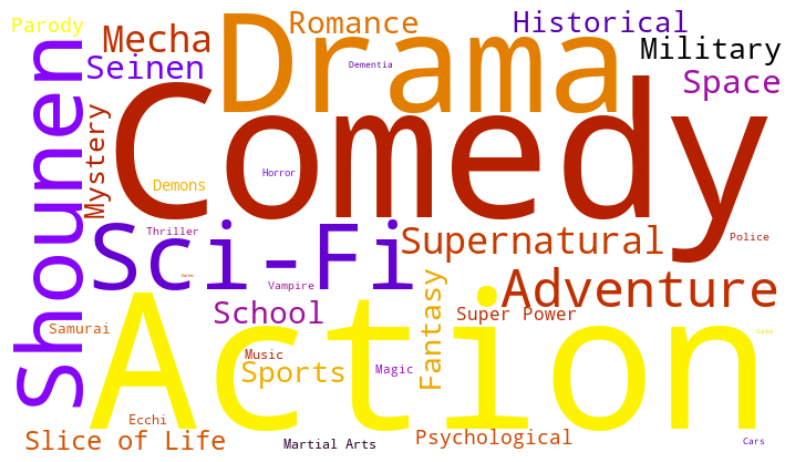

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


In [136]:
get_user_preferences(11880 , rating_df, anime_df , plot=True)

In [137]:
def get_user_recommendations(similar_users , user_pref ,df , synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id) , rating_df, df)

        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i,anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name,str):
                    frame = getAnimeFrame(anime_name,df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]
                    synopsis = getSynopsis(int(anime_id),synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis": synopsis
                    })
    return pd.DataFrame(recommended_animes).head(n)
            



    

In [138]:
similar_users =find_similar_users(int(11880),user_weights,user2user_encoded,user2user_decoded)

In [139]:
user_pref = get_user_preferences(11880 , rating_df, anime_df , plot=False)

In [140]:
get_user_recommendations(similar_users,user_pref,anime_df, synopsis_df,rating_df,n=1)

,n,anime_name,Genres,Synopsis
0,9,Attack on Titan,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen","Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."


## HYBRID RECOMMENDER SYSTEM

In [141]:
def hybrid_recommendation(user_id , user_weight=0.5, content_weight =0.5):

    ## User Recommndation

    similar_users =find_similar_users(user_id,user_weights,user2user_encoded,user2user_decoded)
    user_pref = get_user_preferences(user_id , rating_df, anime_df)
    user_recommended_animes =get_user_recommendations(similar_users,user_pref,anime_df, synopsis_df,rating_df)
    

    user_recommended_anime_list = user_recommended_animes["anime_name"].tolist()
    print(user_recommended_anime_list)

    #### Content recommendation
    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, anime_df, synopsis_df)

        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar anime found {anime}")
    
    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weight

    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weight  

    sorted_animes = sorted(combined_scores.items() , key=lambda x:x[1] , reverse=True)

    return [anime for anime , score in sorted_animes[:10]] 



In [143]:
recommended_animes = hybrid_recommendation(user_id=11880, user_weight=0.7, content_weight=0.3)
print(recommended_animes)


['Attack on Titan', 'A Silent Voice', 'Noragami Aragoto', 'Fate/stay night [Unlimited Blade Works] Season 2', 'The Future Diary', 'Fate/stay night [Unlimited Blade Works]', 'ReLIFE', 'Sword Art Online II', 'Death Note', 'Code Geass:Lelouch of the Rebellion R2']
Anime closest to Attack on Titan:
Error: index 0 is out of bounds for axis 0 with size 0
No similar anime found Attack on Titan
Anime closest to A Silent Voice:
Error: index 0 is out of bounds for axis 0 with size 0
No similar anime found A Silent Voice
Anime closest to Noragami Aragoto:
Anime closest to Fate/stay night [Unlimited Blade Works] Season 2:
Anime closest to The Future Diary:
Error: index 0 is out of bounds for axis 0 with size 0
No similar anime found The Future Diary
Anime closest to Fate/stay night [Unlimited Blade Works]:
Error: index 0 is out of bounds for axis 0 with size 0
No similar anime found Fate/stay night [Unlimited Blade Works]
Anime closest to ReLIFE:
Error: index 0 is out of bounds for axis 0 with siz